# Financial time series

In [1]:
from __future__ import print_function
import numpy
import numpy as np
from numpy import arange
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import pylab as plt
from functools import partial
from itertools import chain
import seaborn as sns
from scipy import stats

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

#from motion import *

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

/Users/julesroche/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## remarque
1. train data=batchdata: time series de dimension 49 such as batchdata.shape=(3826,49) (format: normalized data)
2. mean.shape=std.shape=(49,1): in order to normalize data input
3. seqlen: longeur de sequence (1 sequence: walking, runing => motion sequence)
4. loard_data: turn bathcdata into a theano tensor "shared_x". To access value: used get_values

In [13]:
def get_norm(data):
    mu=np.mean(data,axis=0)
    sig=np.std(data,axis=0)
    data_n=(data-mu)/sig
    return(data_n,mu,sig)

def get_return(Y):
    R=Y.pct_change()[1:]
    return(R)



def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(5, 5))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)

    #show plot
    #plt.show()

### Import portfolio 1

In [3]:
#preprocess data: return+normalize
data_sp=pd.read_csv('prixSPX')
data_sp.head(2)    

prices=data_sp
prices_clean=prices.dropna(axis=1)
prices_clean.columns=[str(i) for i in range(115)]
prices_clean.index=prices_clean['0']

prix=prices_clean[[str(i) for i in range(1,50)]]
del prices_clean['0']
prix.shape

#attention: imperatif d'avoir 3826 dates
N_actif=6
prix_a=np.array(prix)[:3827,0:N_actif]
print(prix_a.shape)

R_true=np.array(get_return(pd.DataFrame(prix_a)))
print(R_true.shape)
R,mu,sig=get_norm(get_return(pd.DataFrame(prix_a))) #output: DataFrame and series
print(R.shape)
#transfrom into array
R_clean=np.array(R)
mu_clean=np.array(mu)
sig_clean=np.array(sig)
type(sig_clean)

(3827, 6)
(3826, 6)
(3826, 6)


numpy.ndarray

In [4]:
def get_price(p_ini,R):
    s=p_ini*np.cumprod((R+1),axis=0)
    prix=np.insert(s,0,p_ini,axis=0)
    return(prix)

def denormalize(Rn,mu,sig):
    R_true=np.zeros((Rn.shape[0],Rn.shape[1]))
    for i in range(Rn.shape[0]):
        R_true[i,:]=Rn[i,:]*sig+mu
    return(R_true)

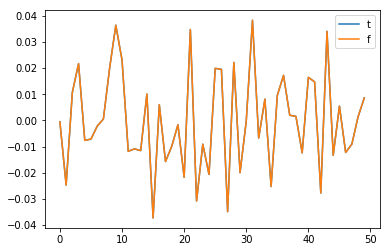

In [5]:
#1er test de denormalization
n_a=0
idx=50
plt.plot(R_true[idx:idx+50,n_a],label='t')
r_tilde=denormalize(R_clean[idx:idx+50,:],mu_clean,sig_clean)
plt.plot(r_tilde[:,n_a],label='f')
plt.legend()

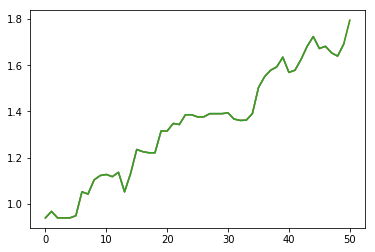

In [6]:
#2 eme test de denormalization: retour aux prix
n_a=3
plt.plot(prix_a[idx:idx+50,n_a])
p_ini=prix_a[idx]
p_tilde=get_price(p_ini,r_tilde)
p_true=get_price(p_ini,R_true[idx:idx+50])
plt.plot(p_true[:,n_a])
plt.plot(p_tilde[:,n_a])

### Import Portfolio 2 (Jiali)

In [7]:
#diversified PF
df_prix=pd.read_csv('multi_asset',index_col='Date')
df_prix.head()
print(df_prix.shape)
prix_a=np.array(df_prix)

#attention: imperatif d'avoir 3826 dates
N_actif=prix_a.shape[1]
print(prix_a.shape)

R_true=np.array(get_return(pd.DataFrame(prix_a)))
print(R_true.shape)
R,mu,sig=get_norm(get_return(pd.DataFrame(prix_a))) #output: DataFrame and series
print(R.shape)
#transfrom into array
R_clean=np.array(R)
mu_clean=np.array(mu)
sig_clean=np.array(sig)
type(sig_clean)

(4176, 7)
(4176, 7)
(4175, 7)
(4175, 7)


numpy.ndarray

In [9]:
#PF Jiali 1
df_pf1=pd.read_excel('PF.xlsx', sheet_name='Ptf_1',index_col='END DATE',parse_dates=True)
del df_pf1['Equity_EM']

In [10]:
prix_a=np.array(df_pf1)
N_actif=prix_a.shape[1]
print(prix_a.shape)

#pre processed data: z-score normailzed daily return
R_true=np.array(get_return(pd.DataFrame(prix_a)))
print(R_true.shape)
R,mu,sig=get_norm(get_return(pd.DataFrame(prix_a))) #output: DataFrame and series
print(R.shape)
#transfrom into array
R_clean=np.array(R)
mu_clean=np.array(mu)
sig_clean=np.array(sig)

(4871, 10)
(4870, 10)
(4870, 10)


In [11]:
R_clean_train=R_clean[:3826]
R_clean_test=R_clean[3826:]
prix_a_train=prix_a[:3826]
prix_a_test=prix_a[3826:]

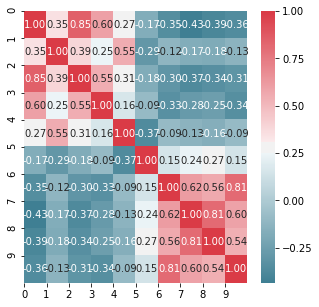

In [14]:
heatMap(get_return(pd.DataFrame(prix_a)))

In [15]:
df_pf1.head()

,Equity_EMU,Equity_HK,Equity_UK,Equity_US_Big,Equity_Japan,Bonds_Australia_10Y,Bonds_Canada_10Y,Bonds_Germany_10Y,Bonds_UK_10Y,Bonds_US_10Y
END DATE,,,,,,,,,,
2001-01-31,3236.56,11269,5008.1,1343.46,11082,93120.754477,72.95,75.11,68.35,62.828125
2001-02-01,3186.76,11339,4976.6,1352.76,10954,93658.283391,73.15,75.19,68.29,63.125000
2001-02-02,3149.08,11325,4987.0,1324.14,10994,93456.340916,72.85,75.20,68.26,62.843750
2001-02-05,3160.52,11087,4996.5,1332.70,10706,93254.943843,72.95,75.38,68.30,62.843750
2001-02-06,3182.72,11166,5016.0,1327.08,10658,93288.358535,72.88,75.32,68.31,62.656250


In [16]:
#process data to feed theano tensor 
def load_return(R_clean):
    R_clean=pd.DataFrame(R_clean)
    #R_clean=R_clean
    #data_std=np.array(S)
    #data_mean=np.array(M)
    
    # put data into shared memory
    seqlen=[438,260,3128]
    shared_x = theano.shared(np.asarray(R_clean, dtype=theano.config.floatX))
    #return shared_x, seqlen, data_mean, data_std
    return shared_x, seqlen


In [17]:
#initialize weights
numpy_rng = numpy.random.RandomState(1234)
numpy_rng.randint(2 ** 30)
initial_W = np.asarray(0.01 * numpy_rng.randn(49,500),dtype=theano.config.floatX)


In [18]:
#RBM parameter: conditionned by n_delay, hidden layer with n_hid units
#nvis: 1 seuls prix pour chaque actifs du PF
n_delay=3
n_vis=R_clean.shape[1]
n_hid=500
n_iter=500
print(R_clean.shape)
print(type(R_clean))
n_vis

(4870, 10)
<class 'numpy.ndarray'>


10

In [19]:
class CRBM(object):
    """Conditional Restricted Boltzmann Machine (CRBM)  """
    def __init__(self, input=None, input_history=None, n_visible=n_vis,
                 n_hidden=n_hid, delay=n_delay, A=None, B=None, W=None, hbias=None,
                 vbias=None, numpy_rng=None,
                 theano_rng=None):
        """
        CRBM constructor. Defines the parameters of the model along with
        basic operations for inferring hidden from visible (and vice-versa),
        as well as for performing CD updates.

        :param input: None for standalone RBMs or symbolic variable if RBM is
        part of a larger graph.

        :param n_visible: number of visible units

        :param n_hidden: number of hidden units

        :param A: None for standalone CRBMs or symbolic variable pointing to a
        shared weight matrix in case CRBM is part of a CDBN network; in a CDBN,
        the weights are shared between CRBMs and layers of a MLP

        :param B: None for standalone CRBMs or symbolic variable pointing to a
        shared weight matrix in case CRBM is part of a CDBN network; in a CDBN,
        the weights are shared between CRBMs and layers of a MLP

        :param W: None for standalone CRBMs or symbolic variable pointing to a
        shared weight matrix in case CRBM is part of a CDBN network; in a CDBN,
        the weights are shared between CRBMs and layers of a MLP

        :param hbias: None for standalone CRBMs or symbolic variable pointing
        to a shared hidden units bias vector in case CRBM is part of a
        different network

        :param vbias: None for standalone RBMs or a symbolic variable
        pointing to a shared visible units bias
        """

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.delay = delay

        if numpy_rng is None:
            # create a number generator
            numpy_rng = numpy.random.RandomState(1234)

        if theano_rng is None:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        if W is None:
            # the output of uniform if converted using asarray to dtype
            # theano.config.floatX so that the code is runable on GPU
            #marice de poids for undirected connection: current visible layer <=> hidden layer
            initial_W = np.asarray(0.01 * numpy_rng.randn(n_visible,
                                                          n_hidden),
                                    dtype=theano.config.floatX)
            # theano shared variables for weights and biases
            W = theano.shared(value=initial_W, name='W')

        if A is None:
            #matrice de poinds for directed graph: passed visible units <=> current visible units
            initial_A = np.asarray(0.01 * numpy_rng.randn(n_visible * delay,
                                                           n_visible),
                                    dtype=theano.config.floatX)
            # theano shared variables for weights and biases
            A = theano.shared(value=initial_A, name='A')

        if B is None:
            #matrice de poinds for directed graph: passed visible units <=> hidden visible units
            initial_B = np.asarray(0.01 * numpy_rng.randn(n_visible * delay,
                                                           n_hidden),
                                    dtype=theano.config.floatX)
            # theano shared variables for weights and biases
            B = theano.shared(value=initial_B, name='B')

        if hbias is None:
            #static biais involved in undirected connection
            # create shared variable for hidden units bias
            hbias = theano.shared(value=numpy.zeros(n_hidden,
                                dtype=theano.config.floatX), name='hbias')

        if vbias is None:
            #static biais involved in undirected connection
            # create shared variable for visible units bias
            vbias = theano.shared(value=numpy.zeros(n_visible,
                                dtype=theano.config.floatX), name='vbias')

        # initialize input layer for standalone CRBM or layer0 of CDBN
        self.input = input
        if not input:
            #symbolic tensor: to feed current visible units noted v
            self.input = T.matrix('input')

        self.input_history = input_history
        if not input_history:
            #symbolic tensor: to feed passed visible units v_<t
            self.input_history = T.matrix('input_history')

        self.W = W
        self.A = A
        self.B = B
        self.hbias = hbias
        self.vbias = vbias
        self.theano_rng = theano_rng
        # **** WARNING: It is not a good idea to put things in this list
        # other than shared variables created in this function.
        self.params = [self.W, self.A, self.B, self.hbias, self.vbias]

    def free_energy(self, v_sample, v_history):
        ''' Function to compute the free energy of a sample conditional
        on the history '''
        #compute dynamic biaises + basic matrix product for undirected connection
        wx_b = T.dot(v_sample, self.W) + T.dot(v_history, self.B) + self.hbias
        ax_b = T.dot(v_history, self.A) + self.vbias
        visible_term = T.sum(0.5 * T.sqr(v_sample - ax_b), axis=1)
        hidden_term = T.sum(T.log(1 + T.exp(wx_b)), axis=1)

        return visible_term - hidden_term

    def propup(self, vis, v_history):
        ''' This function propagates the visible units activation upwards to
        the hidden units

        Note that we return also the pre-sigmoid activation of the layer. As
        it will turn out later, due to how Theano deals with optimizations,
        this symbolic variable will be needed to write down a more
        stable computational graph (see details in the reconstruction cost
        function)
        '''
        #compute prob of h_i=1 knowing v_t and v<t
        pre_sigmoid_activation = T.dot(vis, self.W) + \
                                 T.dot(v_history, self.B) + self.hbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_h_given_v(self, v0_sample, v_history):
        ''' This function infers state of hidden units given visible units '''
        # compute the activation of the hidden units given a sample of the
        # visibles
        #pre_sigmoid_h1, h1_mean = self.propup(v0_sample)
        pre_sigmoid_h1, h1_mean = self.propup(v0_sample, v_history)
        # get a sample of the hiddens given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        
        #sample a state 0 pr 1 given the probabilty computed with the previous function
        h1_sample = self.theano_rng.binomial(size=h1_mean.shape, n=1,
                                             p=h1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_h1, h1_mean, h1_sample]

    def propdown(self, hid, v_history):
        '''This function propagates the hidden units activation downwards to
        the visible units

        Note that we return also the pre_sigmoid_activation of the layer. As
        it will turn out later, due to how Theano deals with optimizations,
        this symbolic variable will be needed to write down a more
        stable computational graph (see details in the reconstruction cost
        function)
        '''
        #compute prob v_i,t knowing h_t and v_<t
        mean_activation = T.dot(hid, self.W.T) + T.dot(v_history, self.A) + \
                          self.vbias
        return mean_activation

    def sample_v_given_h(self, h0_sample, v_history):
        ''' This function infers state of visible units given hidden units '''
        # compute the activation of the visible given the hidden sample
        #pre_sigmoid_v1, v1_mean = self.propdown(h0_sample)
        v1_mean = self.propdown(h0_sample, v_history)
        # get a sample of the visible given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        #v1_sample = self.theano_rng.binomial(size=v1_mean.shape,
        #                                     n=1, p=v1_mean,
        #        dtype = theano.config.floatX)
        
        #ici, on ne fait pas de sample selon lois binomial: on prend la moyenne cad la valeur exact de sortie
        v1_sample = v1_mean  # mean-field
        return [v1_mean, v1_sample]

    def gibbs_hvh(self, h0_sample, v_history):
        ''' This function implements one step of Gibbs sampling,
            starting from the hidden state'''
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample, v_history)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v1_sample,
                                                                   v_history)

        return [v1_mean, v1_sample, pre_sigmoid_h1, h1_mean, h1_sample]

    def gibbs_vhv(self, v0_sample, v_history):
        ''' This function implements one step of Gibbs sampling,
            starting from the visible state'''
        #pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        #pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample,
                                                                   v_history)
        v1_mean, v1_sample = self.sample_v_given_h(h1_sample, v_history)

        return [pre_sigmoid_h1, h1_mean, h1_sample, v1_mean, v1_sample]

    def get_cost_updates(self, lr=0.1, k=1):
        """
        This functions implements one step of CD-k

        :param lr: learning rate used to train the RBM

        :param persistent: None for CD

        :param k: number of Gibbs steps to do in CD-k

        Returns a proxy for the cost and the updates dictionary. The
        dictionary contains the update rules for weights and biases but
        also an update of the shared variable used to store the persistent
        chain, if one is used.
        """

        # compute positive phase
        pre_sigmoid_ph, ph_mean, ph_sample = \
                        self.sample_h_given_v(self.input, self.input_history)

        # for CD, we use the newly generate hidden sample
        chain_start = ph_sample

        # perform actual negative phase
        # in order to implement CD-k we need to scan over the
        # function that implements one gibbs step k times.
        # Read Theano tutorial on scan for more information :
        # http://deeplearning.net/software/theano/library/scan.html
        # the scan will return the entire Gibbs chain
        # updates dictionary is important because it contains the updates
        # for the random number generator
        
        #scan: pour faire des boucles
        [nv_means, nv_samples, pre_sigmoid_nhs, nh_means,
         nh_samples], updates = theano.scan(self.gibbs_hvh,
                    # the None are place holders, saying that
                    # chain_start is the initial state corresponding to the
                    # 5th output
                    outputs_info=[None, None, None, None, chain_start],
                    non_sequences=self.input_history,
                    n_steps=k)

        # determine gradients on CRBM parameters
        # not that we only need the sample at the end of the chain
        #only interested in the last result
        chain_end = nv_samples[-1]

        cost = T.mean(self.free_energy(self.input, self.input_history)) - \
               T.mean(self.free_energy(chain_end, self.input_history))
        # We must not compute the gradient through the gibbs sampling
        gparams = T.grad(cost, self.params, consider_constant=[chain_end])

        # constructs the update dictionary
        for gparam, param in zip(gparams, self.params):
            # make sure that the learning rate is of the right dtype
            if param == self.A:
                # slow down autoregressive updates
                updates[param] = param - gparam * 0.01 * \
                                 T.cast(lr, dtype=theano.config.floatX)
            else:
                updates[param] = param - gparam * \
                                 T.cast(lr, dtype=theano.config.floatX)

        # reconstruction error is a better proxy for CD
        monitoring_cost = self.get_reconstruction_cost(updates, nv_means[-1])
        
        # pseudo-likelihood is a better proxy for PCD
        #nitoring_cost = self.get_pseudo_likelihood_cost(updates)
        
        


        return monitoring_cost, updates

    def get_reconstruction_cost(self, updates, pre_sigmoid_nv):
        """Approximation to the reconstruction error
        """
        # sum over dimensions, mean over cases
        recon = T.mean(T.sum(T.sqr(self.input - pre_sigmoid_nv), axis=1))

        return recon
    
    def get_pseudo_likelihood_cost(self, updates):
        """Stochastic approximation to the pseudo-likelihood"""

        # index of bit i in expression p(x_i | x_{\i})
        bit_i_idx = theano.shared(value=0, name='bit_i_idx')

        # binarize the input image by rounding to nearest integer
        xi = T.round(self.input)

        # calculate free energy for the given bit configuration
        fe_xi = self.free_energy(xi, self.input_history)

        # flip bit x_i of matrix xi and preserve all other bits x_{\i}
        # Equivalent to xi[:,bit_i_idx] = 1-xi[:, bit_i_idx], but assigns
        # the result to xi_flip, instead of working in place on xi.
        xi_flip = T.set_subtensor(xi[:, bit_i_idx], 1 - xi[:, bit_i_idx])

        # calculate free energy with bit flipped
        fe_xi_flip = self.free_energy(xi_flip, self.input_history)

        # equivalent to e^(-FE(x_i)) / (e^(-FE(x_i)) + e^(-FE(x_{\i})))
        cost = T.mean(self.n_visible * T.log(T.nnet.sigmoid(fe_xi_flip -
                                                            fe_xi)))

        # increment bit_i_idx % number as part of updates
        updates[bit_i_idx] = (bit_i_idx + 1) % self.n_visible

        return cost

    def generate(self, orig_data, orig_history, n_samples, n_gibbs):
        """ Given initialization(s) of visibles and matching history, generate
        n_samples in future.

        orig_data : n_seq by n_visibles array
            initialization for first frame
        orig_history : n_seq by delay * n_visibles array
            delay-step history
        n_samples : int
            number of samples to generate forward: number of days
        n_gibbs : int
            number of alternating Gibbs steps per iteration"""
        n_seq = orig_data.shape[0] #cad 4: pour le nombe de sequence a differents date qu'on souhaite generer
        persistent_vis_chain = theano.shared(orig_data)# convert data into symbolic tensor
        persistent_history = theano.shared(orig_history)

        #persistent_history = T.matrix('persistent_history')

        [presig_hids, hid_mfs, hid_samples, vis_mfs, vis_samples], updates =  \
                            theano.scan(self.gibbs_vhv,
                                    outputs_info=[None, None, None, None,
                                                    persistent_vis_chain],
                                    non_sequences=persistent_history,
                                    n_steps=n_gibbs)

        # add to updates the shared variable that takes care of our persistent
        # chain
        # initialize next visible with current visible
        # shift the history one step forward
        updates[persistent_vis_chain] = vis_samples[-1]
        updates[persistent_history] = T.concatenate(
                             (vis_samples[-1],
                                 persistent_history[:, :(self.delay - 1) * \
                                                    self.n_visible],
                              ), axis=1)
        # construct the function that implements our persistent chain.
        # we generate the "mean field" activations for plotting and the actual
        # samples for reinitializing the state of our persistent chain
        sample_fn = theano.function([], [vis_mfs[-1], vis_samples[-1]],
                            updates=updates,
                            name='sample_fn')

        #vis_mf, vis_sample = sample_fn()
        #print orig_data[:,1:5]
        #print vis_mf[:,1:5]
        generated_series = np.empty((n_seq, n_samples, self.n_visible))
        for t in range(n_samples):
            #print("Generating frame %d" % t)
            vis_mf, vis_sample = sample_fn()
            generated_series[:, t, :] = vis_mf
        return generated_series



def train_crbm(learning_rate=1e-3, training_epochs=n_iter,
             dataset='./data/motion.mat', batch_size=100,
             n_hidden=n_hid, delay=n_delay):
    """
    Demonstrate how to train a CRBM.
    This is demonstrated on mocap data.

    :param learning_rate: learning rate used for training the CRBM

    :param training_epochs: number of epochs used for training

    :param dataset: path the the dataset (matlab format)

    :param batch_size: size of a batch used to train the RBM

    """

    rng = numpy.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    # batchdata is returned as theano shared variable floatX
    #batchdata, seqlen, data_mean, data_std = load_data(dataset)
    #batchdata, seqlen, data_mean, data_std = load_return()
    batchdata, seqlen = load_return(R_clean_train)
    print('ok')

    # compute number of minibatches for training, validation and testing
    n_train_batches = (batchdata.get_value(borrow=True).shape[0] / delay * len(seqlen)) / batch_size
    n_dim = batchdata.get_value(borrow=True).shape[1]

    # valid starting indices
    batchdataindex = []
    last = 0
    #seqlen: liste de 3 elements
    for s in seqlen:
        batchdataindex += list(range(last + delay, last + s))
        last += s

    permindex = np.array(batchdataindex)
    rng.shuffle(permindex)

    # allocate symbolic variables for the data
    index = T.lvector()    # index to a [mini]batch
    index_hist = T.lvector()  # index to history
    x = T.matrix('x')  # the data
    x_history = T.matrix('x_history')

    #theano.config.compute_test_value='warn'
    #x.tag.test_value = np.random.randn(batch_size, n_dim)
    #x_history.tag.test_value = np.random.randn(batch_size, n_dim*delay)

    # initialize storage for the persistent chain
    # (state = hidden layer of chain)

    # construct the CRBM class
    crbm = CRBM(input=x, input_history=x_history, n_visible=n_dim, \
                n_hidden=n_hidden, delay=delay, numpy_rng=rng,
                theano_rng=theano_rng)

    # get the cost and the gradient corresponding to one step of CD-15
    cost, updates = crbm.get_cost_updates(lr=learning_rate, k=1)
    

    #################################
    #     Training the CRBM         #
    #################################

    # the purpose of train_crbm is solely to update the CRBM parameters
    train_crbm = theano.function([index, index_hist], cost,
           updates=updates,
           givens={x: batchdata[index], \
                      x_history: batchdata[index_hist].reshape((
                       batch_size, delay * n_dim))},
           name='train_crbm')

    plotting_time = 0.
    start_time = time.clock()

    mean_cost_list = []
    # go through training epochs
    for epoch in range(training_epochs):

        # go through the training set
        mean_cost = []
        for batch_index in range(int(n_train_batches)):

            # indexing is slightly complicated
            # build a linear index to the starting frames for this batch
            # (i.e. time t) gives a batch_size length array for data
            data_idx = permindex[batch_index * batch_size:(batch_index + 1) \
                                 * batch_size]

            # now build a linear index to the frames at each delay tap
            # (i.e. time t-1 to t-delay)
            # gives a batch_size x delay array of indices for history
            hist_idx = np.array([data_idx - n for n in range(1, delay + 1)]).T

            this_cost = train_crbm(data_idx, hist_idx.ravel())
            #print batch_index, this_cost
            mean_cost += [this_cost]

        mean_cost_list.append(numpy.mean(mean_cost))
        print('Training epoch %d, cost is ' % epoch, mean_cost_list[-1])

    cost_plot(mean_cost_list)
    end_time = time.clock()

    pretraining_time = (end_time - start_time)

    print(('Training took %f minutes' % (pretraining_time / 60.)))

    return crbm, batchdata

def cost_plot(mean_cost):
    import pylab as plt

    plt.plot(mean_cost, ',')
    plt.xlabel('epoch')
    plt.ylabel('mean cost')
    plt.savefig('cost.png')

def plot(data_idx, bd, generated_series):
    import pylab as plt

    n_samples = generated_series[0].shape[0] - crbm.delay
    # plot first dimension of each sequence
    for i in range(len(generated_series)):
        # original
        start = data_idx[i]
        plt.subplot(len(generated_series), 1, i+1)
        plt.plot(bd[start - crbm.delay:start + n_samples - crbm.delay, 1],
                 label='true', linestyle=':')
        plt.plot(generated_series[i, :n_samples, 1], label='predicted',
                 linestyle='-')
        plt.yticks(fontsize=9)

    leg = plt.legend()
    ltext = leg.get_texts()  # all the text.Text instance in the legend
    plt.setp(ltext, fontsize=9)

    plt.tight_layout()
    plt.savefig('result.png')



In [20]:
crbm, batchdata = train_crbm()

ok


/Users/julesroche/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:445: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Training epoch 0, cost is  10.962502029684023
Training epoch 1, cost is  10.918290610831587
Training epoch 2, cost is  10.930412367506776
Training epoch 3, cost is  10.864348309389907
Training epoch 4, cost is  10.85297154397623
Training epoch 5, cost is  10.837817699216489
Training epoch 6, cost is  10.800268782721107
Training epoch 7, cost is  10.790493925194747
Training epoch 8, cost is  10.768265143827595
Training epoch 9, cost is  10.75906419264135
Training epoch 10, cost is  10.698759336935344
Training epoch 11, cost is  10.697077390303136
Training epoch 12, cost is  10.67254912216718
Training epoch 13, cost is  10.639890431538822
Training epoch 14, cost is  10.585103082542446
Training epoch 15, cost is  10.553017740792253
Training epoch 16, cost is  10.504220152103088
Training epoch 17, cost is  10.42711992200064
Training epoch 18, cost is  10.418372128981764
Training epoch 19, cost is  10.359752050062125
Training epoch 20, cost is  10.330471247092978
Training epoch 21, cost is 

SystemError: <class 'range'> returned a result with an error set
Apply node that caused the error: Elemwise{Composite{scalar_sigmoid((i0 + i1 + i2))}}[(0, 0)](Dot22.0, Dot22.0, InplaceDimShuffle{x,0}.0)
Toposort index: 35
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, row)]
Inputs shapes: [(100, 500), (100, 500), (1, 500)]
Inputs strides: [(4000, 8), (4000, 8), (4000, 8)]
Inputs values: ['not shown', 'not shown', 'not shown']
Outputs clients: [[Sum{axis=[0], acc_dtype=float64}(Elemwise{Composite{scalar_sigmoid((i0 + i1 + i2))}}[(0, 0)].0), Elemwise{TrueDiv}[(0, 0)](Elemwise{Composite{scalar_sigmoid((i0 + i1 + i2))}}[(0, 0)].0, InplaceDimShuffle{x,x}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [18]:
# Generate some sequences (in parallel) from CRBM
# Using training data as initialization
# pick some starting points for each sequence
N_sim=10
data_idx=np.array([100 for i in range(N_sim)])
#orig_data = numpy.asarray(batchdata.get_value(borrow=True)[data_idx],dtype=theano.config.floatX)
orig_data=R_clean_test[data_idx]
hist_idx = np.array([data_idx - n for n in range(1, crbm.delay + 1)]).T
hist_idx = hist_idx.ravel()

#orig_history = numpy.asarray(
#    batchdata.get_value(borrow=True)[hist_idx].reshape(
#    (len(data_idx), crbm.delay * crbm.n_visible)),
#    dtype=theano.config.floatX)

orig_history=numpy.asarray(R_clean_test[hist_idx].reshape(len(data_idx), crbm.delay * crbm.n_visible))

generated_series = crbm.generate(orig_data, orig_history, n_samples=20, n_gibbs=25)
# append initialization
generated_series = np.concatenate((orig_history.reshape(len(data_idx),
                                                        crbm.delay,
                                                        crbm.n_visible \
                                                        )[:, ::-1, :],
                                   generated_series), axis=1)

bd = batchdata.get_value(borrow=True)


In [19]:
def generate_scenario(N_sim,indice,data,f):
    #bd = batchdata.get_value(borrow=True)
    data_idx=np.array([indice for i in range(N_sim)])
    orig_data=data[data_idx]
    hist_idx = np.array([data_idx - n for n in range(1, crbm.delay + 1)]).T
    hist_idx = hist_idx.ravel()
    orig_history=numpy.asarray(data[hist_idx].reshape(len(data_idx), crbm.delay * crbm.n_visible))
    generated_series = crbm.generate(orig_data, orig_history, n_samples=f+crbm.delay, n_gibbs=25)
    # append initialization
    generated_series = np.concatenate((orig_history.reshape(len(data_idx),
                                                            crbm.delay,
                                                            crbm.n_visible \
                                                            )[:, ::-1, :],
                                       generated_series), axis=1)
    return(generated_series,data_idx)
    

In [20]:
generated_series,data_idx=generate_scenario(50,200,R_clean_train,8)


In [21]:
def plot_new(data_idx, bd, generated_series,n_dim):
    n_samples = generated_series[0].shape[0] - crbm.delay
    # plot first dimension of each sequence
    for i in range(len(generated_series)-1):
        # original
        start = data_idx[i]
        plt.figure()
        plt.plot(bd[start - crbm.delay:start + n_samples - crbm.delay, n_dim],
                 label='true', linestyle=':')
        plt.plot(generated_series[i, :n_samples, n_dim], label='generated',
                 linestyle='-')
        plt.legend()
        
    plt.legend()

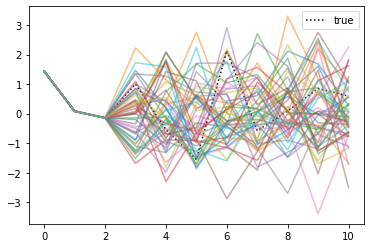

In [22]:
#output: return normalisé en sortie du RBM
def plot_sceanrio(data_idx, data_real, generated_series,n_dim):
    n_samples = generated_series[0].shape[0] - crbm.delay
    start=data_idx[0]
    plt.plot(data_real[start - crbm.delay:start + n_samples - crbm.delay, n_dim],label='true', linestyle=':',color='black')#true_data
    plt.legend()
    for i in range(len(generated_series)):
        plt.plot(generated_series[i, :n_samples, n_dim], label='generated',linestyle='-',alpha=0.5)
    
num_actif=2
bd = batchdata.get_value(borrow=True)
plot_sceanrio(data_idx, bd, generated_series,num_actif)    

In [53]:
#input: bd : toutes la datset des prix
#output: retrun normalisé
def get_true_return_idx(data_idx,generated_series,data_prix):
    n_samples = generated_series[0].shape[0] - crbm.delay
    start=data_idx[0]
    return(data_prix[start - crbm.delay:start + n_samples - crbm.delay+1])

def get_return_horizon_v2(P):
    prix_last=P[0]
    prix_b=P[-1]
    return(prix_last/prix_b -1)

def get_return_horizon(P,f):
    ind_max=P.shape[0]-1
    prix_last=P[ind_max]
    prix_b=P[ind_max-f]
    return(prix_last/prix_b -1)

#generated return for one date controled by data_index
#output: prix fake dans la bonne echelle de prix
#w: fenetre de jours en backward dans le passé
def get_fake_return(data_idx, generated_series,data_prix,w):
    n_samples = generated_series[0].shape[0] - crbm.delay
    start=data_idx[0]
    prix_true=get_true_return_idx(data_idx,generated_series,data_prix)
    prix_true_w=np.vstack((data_prix[data_idx[0]-w+crbm.delay:data_idx[0]],prix_true))
    
    P_f=np.zeros((len(generated_series),n_samples+1,N_actif))
    P_f_w=np.zeros((len(generated_series),w+n_samples+1-crbm.delay,N_actif))
    R_f=[]
    for i in range(len(generated_series)):
        r_fake_n=generated_series[i,:n_samples,:]
        r_fake=denormalize(r_fake_n,mu_clean,sig_clean)
        R_f.append(r_fake)
        p_ini=data_prix[start - crbm.delay]
        price_fake=get_price(p_ini,r_fake)
        P_f[i]=price_fake
        prix_fake_w=np.vstack((data_prix[data_idx[0]-w+crbm.delay:data_idx[0]],price_fake))
        P_f_w[i]=prix_fake_w
    P_moy=np.mean(P_f,axis=0)
    prix_moy_w=np.vstack((data_prix[data_idx[0]-w+crbm.delay:data_idx[0]],P_moy))
    mu=get_return_horizon(P_moy,8)
    sig=get_return(pd.DataFrame(prix_true_w)).cov()
    
    R_f=np.array(R_f)
    
    return(P_f,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,sig,R_f)

#P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w=get_fake_return(data_idx,generated_series,prix_a_train,w) 
#p_true=get_true_return_idx(data_idx,generated_series,prix_a_train)

(49, 10)


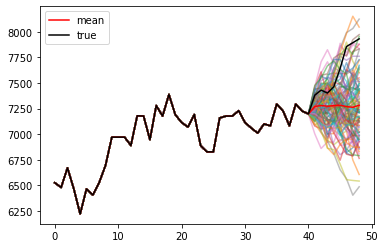

In [54]:
#indice: date de debut de la generation
#f: nombre de jours de generation
#w: nombre de jçurs observé ds le passé
#indice: choix de l'actifs à afficher
#R_data: R_clean_train/test
#data: prix_a_train/test
def affiche_scenario(N_sim,indice,R_data,prix_data,w,f,num_actif):
    generated_series,data_idx=generate_scenario(N_sim,indice,R_data,f)
    P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,_,R_f=get_fake_return(data_idx,generated_series,prix_data,w)
    p_true=get_true_return_idx(data_idx,generated_series,prix_data)
    for i in range(P.shape[0]):
        plt.plot(P_f_w[i,:,num_actif],alpha=0.5)
    plt.plot(prix_moy_w[:,num_actif],color='red',label='mean')
    plt.plot(prix_true_w[:,num_actif],color='black',label='true')
    plt.legend()
    print(prix_moy_w.shape)
    
    
    
affiche_scenario(100,200,R_clean_train,prix_a_train,40,8,1)                  
                  

(49, 10)


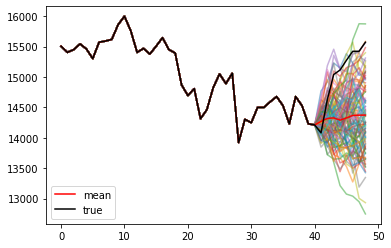

In [55]:
#scenario_test
affiche_scenario(100,200,R_clean_test,prix_a_test,40,8,4)

(50, 12, 10)


(50, 11, 10)

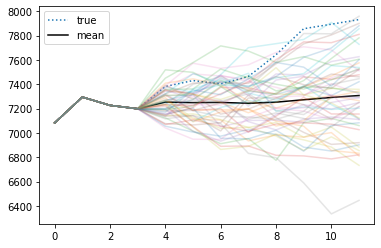

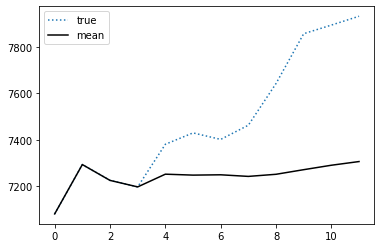

In [142]:
#train dataset
P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,sig,R_f=get_fake_return(data_idx,generated_series,prix_a_train,40) 
p_true=get_true_return_idx(data_idx,generated_series,prix_a_train)
indice=1
print(P.shape)

plt.figure()
plt.plot(p_true[:,indice],label='true',linestyle=':')
plt.plot(P_moy[:,indice],label='mean',color='black')
plt.legend()
for i in range(P.shape[0]):
    plt.plot(P[i,:,indice],alpha=0.2)
    
plt.figure()
plt.plot(p_true[:,indice],label='true',linestyle=':')
plt.plot(P_moy[:,indice],label='mean',color='black')             
plt.legend()


(50, 49, 10)

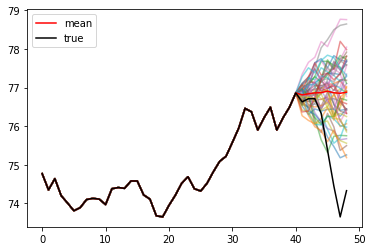

In [32]:
indice=6
for i in range(P.shape[0]):
    plt.plot(P_f_w[i,:,indice],alpha=0.5)
plt.plot(prix_moy_w[:,indice],color='red',label='mean')
plt.plot(prix_true_w[:,indice],color='black',label='true')
plt.legend()
P_f_w.shape
#prix_true.shape

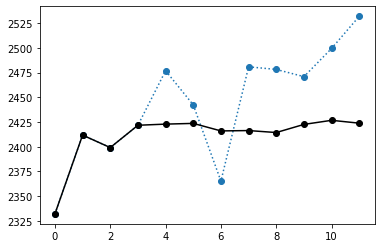

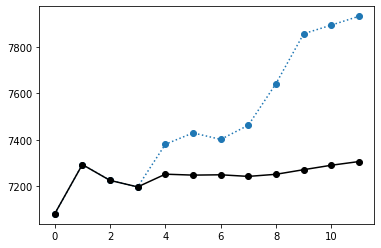

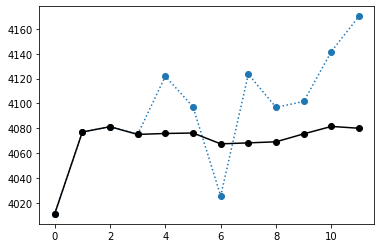

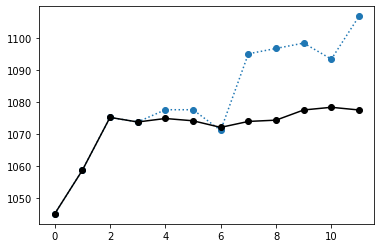

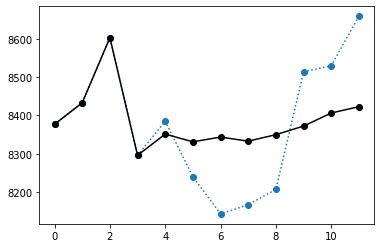

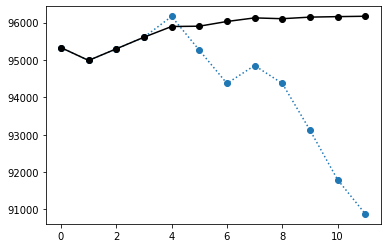

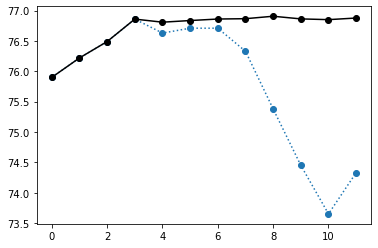

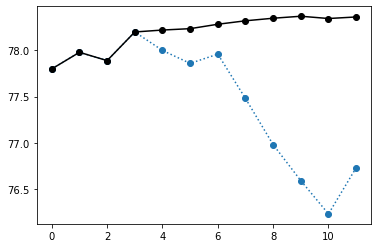

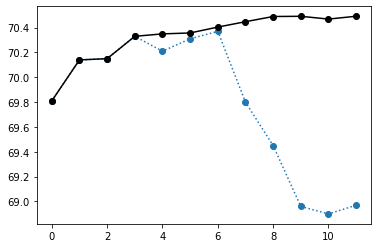

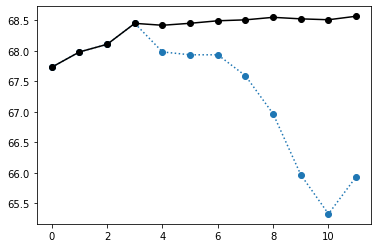

In [33]:
for indice in range(N_actif):
    plt.figure()
    plt.plot(p_true[:,indice],label='true',linestyle=':',marker='o')
    plt.plot(P_moy[:,indice],label='mean',color='black',marker='o')

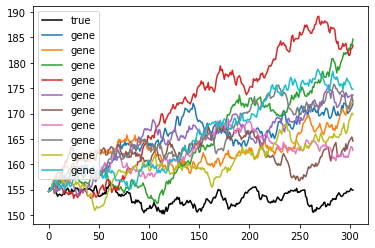

In [140]:
def affiche_scenario_focus(N_sim,indice,R_data,prix_data,w,f,num_actif):
    generated_series,data_idx=generate_scenario(N_sim,indice,R_data,f)
    P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,_,R=get_fake_return(data_idx,generated_series,prix_data,w)
    p_true=get_true_return_idx(data_idx,generated_series,prix_data)
    plt.plot(p_true[:,num_actif],label='true',color='black')
    for i in range(P.shape[0]):
        plt.plot(P[i,:,num_actif],label='gene')
    #plt.plot(prix_moy_w[:,num_actif],color='red',label='mean')
    plt.legend()
    
affiche_scenario_focus(10,200,R_clean_train,prix_a_test,40,300,7)



In [141]:
R.shape

(126, 10, 11, 10)

## Time dependance analysis

In [134]:
def aff_autocorr(n_lag,s):
    A=[]

    for k in range(0,n_lag+1):
        A.append(s.autocorr(lag=k))

    Ad=pd.Series(A)
    x=np.array([i for i in range(0,n_lag+1)])
    plt.plot(x,A)
    plt.xlabel('lag')
    plt.ylabel('ACF')

In [135]:
def compare_return(N_sim,indice,R_data,prix_data,w,f,num_actif):
    generated_series,data_idx=generate_scenario(N_sim,indice,R_data,f)
    P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,_,R=get_fake_return(data_idx,generated_series,prix_data,w)
    p_true=get_true_return_idx(data_idx,generated_series,prix_data)
    r_gene=R[:,:,num_actif].reshape(f+crbm.delay,)
    r_true=np.array(get_return(pd.DataFrame(p_true[:,num_actif])))[:,0]
    return(r_gene,r_true)

a,b=compare_return(1,100,R_clean_train,prix_a_test,40,300,7)

In [136]:
true=pd.Series(b)
gene=pd.Series(a)

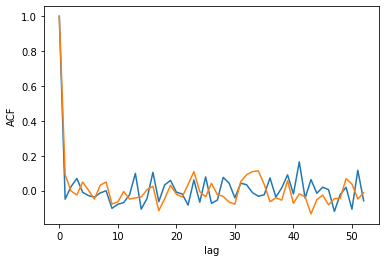

In [137]:
aff_autocorr(52,true)
aff_autocorr(52,gene)

## KS test

In [168]:
N_sim=300

In [169]:
generated_series,data_idx=generate_scenario(N_sim,200,R_clean_train,300)
P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,sig,R_f=get_fake_return(data_idx,generated_series,prix_a_train,40) 
p_true=get_true_return_idx(data_idx,generated_series,prix_a_train)

indice
r_true=np.array(get_return(pd.DataFrame(p_true)))[:,indice]
R_f_ind=R_f[:,:,indice]



In [170]:
R_f_ind.shape
r_gene=R_f_ind[1,:]
r_gene.shape

(303,)

In [171]:
c=0
for i in range(N_sim):
    print(i)
    r_gene=R_f_ind[i,:]

    xt=np.array(r_true).reshape(len(r_true),)
    yt=np.array(r_gene).reshape(len(r_gene),)
    p_value=stats.ks_2samp(xt, yt)[1]
    print('pvalue',stats.ks_2samp(xt, yt)[1])
    if p_value>0.01:
        c+=1
        print('same distribution')


0
pvalue 0.06807563564256798
same distribution
1
pvalue 0.010111864732704997
same distribution
2
pvalue 0.02173571745246821
same distribution
3
pvalue 0.0033183262317010476
4
pvalue 0.0018257187703752526
5
pvalue 0.016955144533887717
same distribution
6
pvalue 0.00442868921802217
7
pvalue 0.05490720581821277
same distribution
8
pvalue 0.03501103413099357
same distribution
9
pvalue 0.027678407812131184
same distribution
10
pvalue 0.0024696738384680015
11
pvalue 0.0024696738384680015
12
pvalue 0.05490720581821277
same distribution
13
pvalue 0.0007083197080143878
14
pvalue 0.0007083197080143878
15
pvalue 0.007730873792091623
16
pvalue 0.005870982573103772
17
pvalue 0.010111864732704997
same distribution
18
pvalue 0.010111864732704997
same distribution
19
pvalue 0.0439913465355976
same distribution
20
pvalue 0.007730873792091623
21
pvalue 0.02173571745246821
same distribution
22
pvalue 0.0439913465355976
same distribution
23
pvalue 0.007730873792091623
24
pvalue 0.027678407812131184
same d

In [172]:
print(c)

166


### QQ plot

Text(0, 0.5, 'gene')

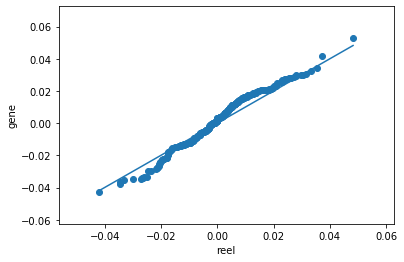

In [174]:
u_t=r_true
u_s=r_gene
T=np.array(u_t)
S=np.array(u_s)

plt.figure()
plt.scatter(np.sort(T.reshape(-1,)), np.sort(S.reshape(-1,)))
x=np.array([np.min(T),np.max(T)])
y=np.array([np.min(T),np.max(T)])
plt.plot(x,y)
plt.xlabel('reel')
plt.ylabel('gene')

## Recovering Correlation matrix

In [67]:
w=40
f_rebalance=8
def get_global_fake_return(N_sim,prix_real,R_real,freq):
    N_days=len(prix_real)
    R_fake_global=[]
    for k_day in range(w,N_days):
        if k_day%freq==0:
            generated_series,data_idx=generate_scenario(N_sim,k_day,R_real,freq)
            P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,sig,R_f=get_fake_return(data_idx,generated_series,prix_real,w)
            R_fake_global.append(R_f)
    R_fake_global=np.array(R_fake_global)
    return(R_fake_global)
        
R=get_global_fake_return(10,prix_a_test,R_clean_test,8)    

In [76]:
R.shape
indice=1
R_1=R[:,:,:,1]
R_1.shape
R_1_flat=R_1.flatten()
R_1_flat.shape
R_1_true=np.array(get_return(pd.DataFrame(prix_a_test[:,1])))


(1044, 1)

<a list of 99 Patch objects>

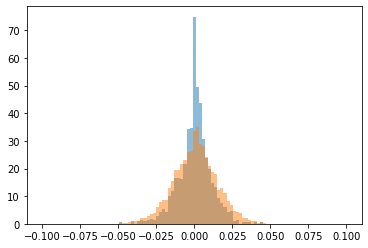

In [78]:
#enriching histogram: could be useful for var_calculation
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(R_1_true, bins,density=True,alpha=0.5)[2]
plt.hist(R_1_flat, bins,density=True,alpha=0.5)[2]

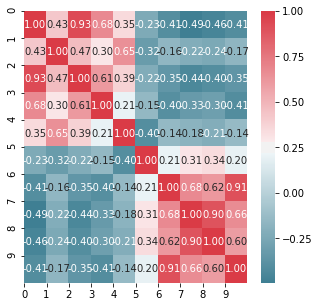

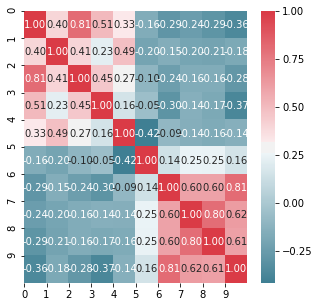

In [100]:
R_gf=np.zeros((R_1_flat.shape[0],prix_a.shape[1]))
for i in range(R_gf.shape[1]):
    R_1=R[:,:,:,i].flatten()
    R_gf[:,i]=R_1

heatMap(pd.DataFrame(R_gf))
heatMap(get_return(pd.DataFrame(prix_a_test)))
    

# PF optimization

In [340]:
w=40
f_rebalance=8
w_boud=(0,1)

In [341]:
def get_optimal_weight(mu,cov_sig):
    ef = EfficientFrontier(mu, cov_sig,weight_bounds=w_boud)
    raw_weights =ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    w_optimal=np.array(list(chain(cleaned_weights.values())))
    return(w_optimal)

def cumreturn(ret):
    return((1+ret).cumprod())

In [342]:
#price_real: prix reel dans la dataset de test
#R_real=R_clean_test/train
#freq: frequence de rebalancement
def get_strat_value_RBM(N_sim,prix_real,R_real,freq):
    N_days=len(prix_real)
    W_f=[]
    R_f=[]
    prix_tot=[]
    r_pf=[]
    for k_day in range(w,N_days):
        if k_day%freq==0:
            generated_series,data_idx=generate_scenario(N_sim,k_day,R_real,freq)
            P,P_moy,mu,P_f_w,prix_true_w,prix_moy_w,sig=get_fake_return(data_idx,generated_series,prix_real,w)
            
        w_opt=get_optimal_weight(mu,sig)
        W_f.append(w_opt)
        R_f.append(mu)
    #PF value
    r_true=np.array(get_return(pd.DataFrame(prix_real)))
    print(r_true.shape)
    l_max=len(r_true)
    r_true_period=r_true[w-1:,:]
    print(r_true_period.shape)
    value_pf=np.sum(W_f*r_true_period,axis=1)
    return(W_f,R_f,value_pf,prix_tot,r_true_period)
    
        
W_f,R_f,v,prix_tot,r_true_period=get_strat_value_RBM(10,prix_a_test,R_clean_test,f_rebalance)


(1044, 10)
(1005, 10)


(1005,)

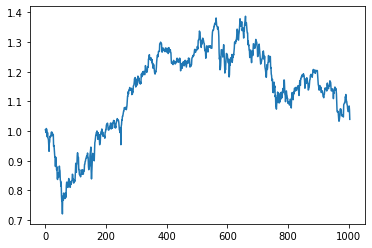

In [343]:
value_RBM=cumreturn(v)
plt.plot(value_RBM)
value_RBM.shape


In [348]:
df_v=pd.DataFrame(v)
#df_v.to_csv('v_CRBM_pf1')
df_v.shape

(1005, 1)

In [344]:

print(len(R_f))
R_f_a=np.array(R_f)
R_f_a[18:25]


1005


array([[ 0.01712739,  0.0319821 ,  0.01265731,  0.01744597,  0.01566631,
         0.00193025, -0.00448249, -0.00171864, -0.0012309 , -0.00329963],
       [ 0.01712739,  0.0319821 ,  0.01265731,  0.01744597,  0.01566631,
         0.00193025, -0.00448249, -0.00171864, -0.0012309 , -0.00329963],
       [ 0.01712739,  0.0319821 ,  0.01265731,  0.01744597,  0.01566631,
         0.00193025, -0.00448249, -0.00171864, -0.0012309 , -0.00329963],
       [ 0.01712739,  0.0319821 ,  0.01265731,  0.01744597,  0.01566631,
         0.00193025, -0.00448249, -0.00171864, -0.0012309 , -0.00329963],
       [ 0.01712739,  0.0319821 ,  0.01265731,  0.01744597,  0.01566631,
         0.00193025, -0.00448249, -0.00171864, -0.0012309 , -0.00329963],
       [ 0.01712739,  0.0319821 ,  0.01265731,  0.01744597,  0.01566631,
         0.00193025, -0.00448249, -0.00171864, -0.0012309 , -0.00329963],
       [-0.00704293, -0.01628094, -0.00583984, -0.00127744, -0.00594234,
        -0.00117717,  0.00318873,  0.00458995

In [345]:
W_f_a=np.array(W_f)
W_f

[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),


## remarques:
1. batchdata.shape=(3826,49): tensor. Pour avoir les valeurs: batchdata.getvalue()
2. orig_data valeurs accocié a data_index example: e= batchdata.getvalue()(index=100)=> renvoie un vecteur de taille (49,) donc batchdata.getvalue()(data_idex) vecteur de taille (4,49)= orig_data
3. hist_idx: vecteur qui a ete flatten renvoie les 6 past index value de chaque composante de org_data= 6*4 =24 // example: si data_index=100 => 6 premeirers valeur de org_data = 94,95,...,100
4. orig_history: valeurs associé au index de hist_idex= comme il y a 6 jours de delays et qu'on est en dimension 49 donc pour chacune des 4 sequence = on a 6 jours * 49 =294 valeurs
5. orig_history est ensuite reshaper sous la forme : (4,6,49)
6. pour former la generated series: on concacten org_history avec les nouvelles valeurs generés
7. generated series: shape=(4,106,49) 106= 6=delay + 100=n_sample: result from the concatenation
8. bd : true value

## importants settings
1. n_sample=100 => ok for spatial correlation // n_sample=1000 => -- bad
2. n_hidden=200, train=2000, delay=3, gibbs=25 => work well
3. plus on augmente la hidden layer, meilleurs est le resultas: bon resultat avec n_hidden=500